In [40]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_log_error, mean_squared_error, confusion_matrix, r2_score, accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
 
import matplotlib.pyplot as plt
import numpy as np

# Clean & organize data

In [9]:
data = pd.read_csv('data/churn.csv')
date = '06.01.2014'
data['last_trip'] = pd.to_datetime(data.last_trip_date)
data['churn'] = (data.last_trip < date)*1


data['last_trip'] = data['last_trip'].dt.date
data['signup_date'] = pd.to_datetime(data.signup_date)
data['signup_date'] = data['signup_date'].dt.date
data['luxury_car_user'] = data.luxury_car_user*1

data = data.dropna()

In [30]:
data.churn.sum()

24410

In [10]:
citydum = pd.get_dummies(data['city'], drop_first=True)
phonedum = pd.get_dummies(data['phone'], drop_first=True)
data = pd.concat([data, citydum], axis=1, sort=False)
data = pd.concat([data, phonedum], axis=1, sort=False)

In [18]:
df = data.drop(columns = ['city', 'phone', 'signup_date', 'last_trip_date', 'last_trip'])
df

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn,King's Landing,Winterfell,iPhone
0,3.67,5.0,4.7,1.10,15.4,4,1,46.2,0,1,0,1
1,8.26,5.0,5.0,1.00,0.0,0,0,50.0,1,0,0,0
2,0.77,5.0,4.3,1.00,0.0,3,0,100.0,1,0,0,1
3,2.36,4.9,4.6,1.14,20.0,9,1,80.0,0,1,0,1
4,3.13,4.9,4.4,1.19,11.8,14,0,82.4,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49993,2.53,4.7,4.8,1.11,11.1,3,1,55.6,0,0,0,1
49994,2.25,4.5,4.6,1.44,37.5,1,0,25.0,1,0,0,1
49995,5.63,4.2,5.0,1.00,0.0,0,0,100.0,0,1,0,1
49997,3.86,5.0,5.0,1.00,0.0,0,1,100.0,1,0,1,0


In [22]:
X = df.drop(columns = 'churn').values
y = df.churn.values
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Logistic regression

In [117]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [118]:
r2_score(y_test, y_hat), mean_squared_log_error(y_test, y_hat), mean_squared_error(y_test, y_hat)

(-0.6920313520574792, 0.196502593416844, 0.4089944026249759)

In [119]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
tn, fp, fn, tp

(0, 4238, 0, 6124)

In [132]:
model.coef_

array([[ 0.0031893 ,  0.03240517, -0.01084014,  0.07479804,  0.00013895,
         0.00011724,  0.06209754,  0.00056553, -0.03618773,  0.01812543,
         0.05272041]])

In [133]:
names = df.columns
names = names.drop('churn')
names

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct',
       'King's Landing', 'Winterfell', 'iPhone'],
      dtype='object')

TypeError: only size-1 arrays can be converted to Python scalars

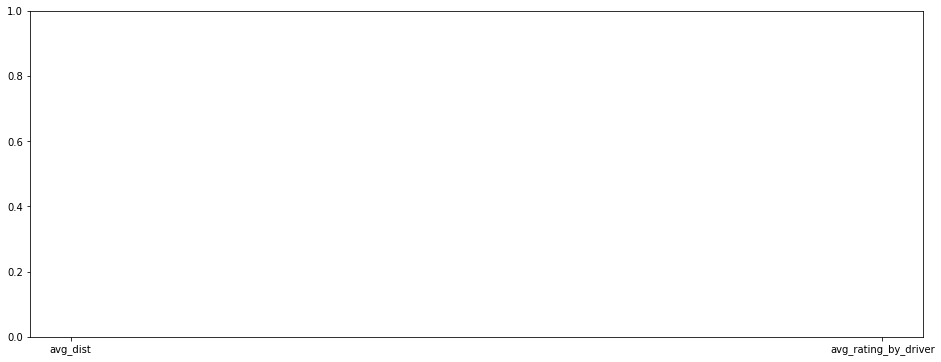

In [130]:
fig, ax = plt.subplots(figsize = (16, 6))
ax.bar(names, coefs)

# Using GradientBoostingClassifier

In [35]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
clf.score(X_test, y_test)

0.783053464582127

In [28]:
clf.feature_importances_

array([0.0189594 , 0.25107787, 0.01988969, 0.00360893, 0.17261808,
       0.03613438, 0.07412197, 0.13694473, 0.16889054, 0.01785689,
       0.09989753])

In [29]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
tn, fp, fn, tp

(2969, 1256, 992, 5145)

# Tunning GradientBoostingClassifier

In [38]:
clf1 = GradientBoostingClassifier(
    loss='deviance', 
    learning_rate=0.1, 
    n_estimators=100, 
    subsample=1.0, 
    criterion='friedman_mse', 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_depth=3, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    init=None, 
    random_state=None, 
    max_features=None, 
    verbose=0, 
    max_leaf_nodes=None, 
    warm_start=False, 
    presort='deprecated', 
    validation_fraction=0.1, 
    n_iter_no_change=None, 
    tol=0.0001, 
    ccp_alpha=0.0)  

In [41]:
clf1.fit(X_train, y_train)
y_pred = clf1.predict(X_test)
clf1.score(X_test, y_test)

0.783053464582127

In [42]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7705396985787054

## learning rate

In [77]:
x_train, x_test, y_train, y_test = train_test_split(X, y)

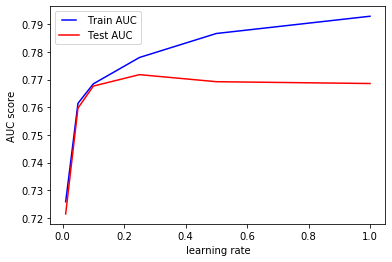

In [54]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

train_results = []
test_results = []
for eta in learning_rates:
   model = GradientBoostingClassifier(learning_rate=eta)
   model.fit(x_train, y_train)
   train_pred = model.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

Increasing learnign rate results in overfitting -> the best learning rate for this model is 0.25

## N_estimators

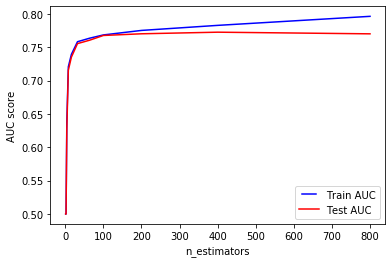

In [57]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 400, 800]
train_results = []
test_results = []
for estimator in n_estimators:
   model = GradientBoostingClassifier(n_estimators=estimator)
   model.fit(x_train, y_train)
   train_pred = model.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlim'

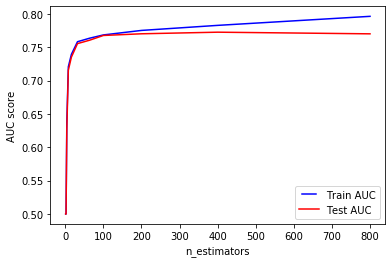

In [64]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [69]:
max(test_results)

0.7725651435436431

In [70]:
test_results.index(0.7725651435436431) 

9

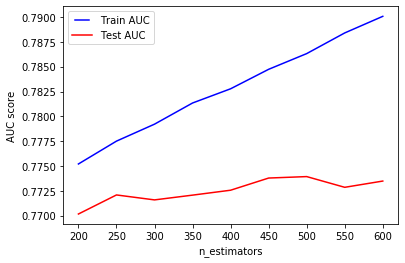

In [71]:
n_estimators = [200, 250, 300, 350, 400, 450, 500, 550, 600]
train_results = []
test_results = []
for estimator in n_estimators:
   model = GradientBoostingClassifier(n_estimators=estimator)
   model.fit(x_train, y_train)
   train_pred = model.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [76]:
test_results.index(max(test_results)) 
max(test_results)

0.773937634349209

In our case, the optimal number of N_estimators is 500

In [83]:
clf3 = GradientBoostingClassifier(
    loss='deviance', 
    learning_rate=0.25, 
    n_estimators=500, 
    subsample=1.0, 
    criterion='friedman_mse', 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_depth=3, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    init=None, 
    random_state=None, 
    max_features=None, 
    verbose=0, 
    max_leaf_nodes=None, 
    warm_start=False, 
    presort='deprecated', 
    validation_fraction=0.1, 
    n_iter_no_change=None, 
    tol=0.0001, 
    ccp_alpha=0.0)  

In [84]:
clf3.fit(x_train, y_train)
y_pred = clf3.predict(x_test)
clf3.score(x_test, y_test)

0.7895193977996525

In [85]:
clf3.feature_importances_

array([0.05970006, 0.21631283, 0.02942025, 0.01724351, 0.17193904,
       0.05058364, 0.06406137, 0.15509726, 0.14023185, 0.01513421,
       0.080276  ])

In [147]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
tn, fp, fn, tp

(3006, 1232, 949, 5175)

In [ ]:
fp / (tp+fp

In [89]:
names = df.columns
names = names.drop('churn')

AttributeError: 'AxesSubplot' object has no attribute 'xticks'

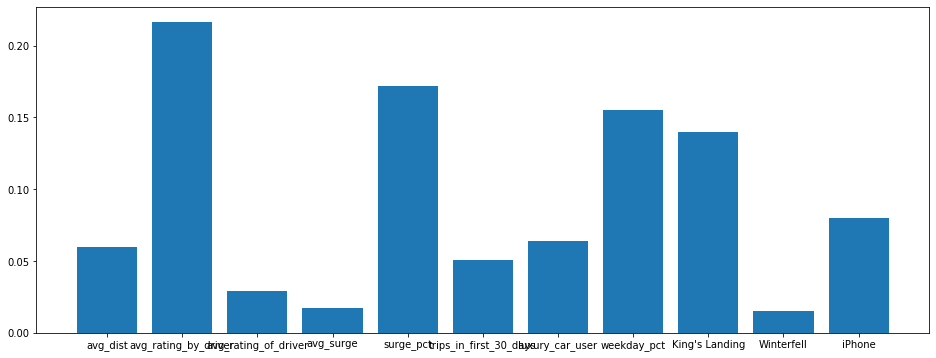

In [98]:
fig, ax = plt.subplots(figsize = (16, 6))
ax.bar(names, clf3.feature_importances_)
ax.xticks(x, names, rotation='vertical')

In [113]:
corr = data[['surge_pct', 'churn']]
mask = corr.churn ==1
corr[mask].surge_pct.mean()

8.72841868086847

In [114]:
mask = corr.churn !=1
corr[mask].surge_pct.mean()

9.142723803933183

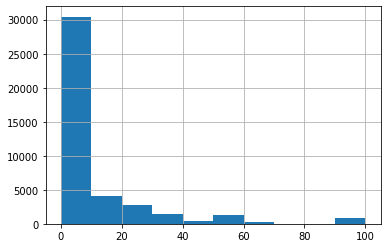

In [115]:
corr.surge_pct.hist()

In [143]:
# potential churns 

preds = clf3.predict(X)
mask2 = preds ==1

In [145]:
# customers who might leave

data[mask2]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,last_trip,churn,King's Landing,Winterfell,iPhone
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,0,50.0,2014-05-05,1,0,0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,0,100.0,2014-01-07,1,0,0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,0,82.4,2014-03-15,1,0,1,0
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,1,100.0,2014-06-06,0,0,1,1
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,0,100.0,2014-01-29,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49991,1.06,5.0,5.0,1.25,Winterfell,2014-06-29,iPhone,2014-01-08,100.0,0,0,0.0,2014-06-29,0,0,1,1
49992,7.58,5.0,1.0,1.00,King's Landing,2014-01-19,iPhone,2014-01-18,0.0,1,0,0.0,2014-01-19,1,1,0,1
49994,2.25,4.5,4.6,1.44,Astapor,2014-05-31,iPhone,2014-01-03,37.5,1,0,25.0,2014-05-31,1,0,0,1
49997,3.86,5.0,5.0,1.00,Winterfell,2014-05-22,Android,2014-01-31,0.0,0,1,100.0,2014-05-22,1,0,1,0
